In [1]:
! pip install --quiet langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python langchain-mistralai gpt4all duckduckgo-search

# Logging Setup

In [2]:
import sys
sys.path.append('..')

import llmtools as t
logger = t.setup_logging()


from dotenv import load_dotenv
load_dotenv()
logger.info('Set environmental variables.')


2024-02-20 09:34:20,824 [MainThread  ] [INFO ]  ---Setup logging---
2024-02-20 09:34:20,849 [MainThread  ] [INFO ]  Set environmental variables.


# Corrective RAG

Refs: https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag_mistral.ipynb

RAG enhanced by self-reflection.
Goal is to:
- Enable correction of poor quality retrieval or generaltion

## Indexing doc

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_mistralai import MistralAIEmbeddings
from langchain_mistralai import ChatMistralAI
from langchain.chat_models import ChatOllama
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.schema.document import Document

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import  DuckDuckGoSearchRun, DuckDuckGoSearchResults

In [4]:
# Model setup

ollama_base_url = "http://192.168.68.99:11434"
llm_model_name = "mistral:instruct"
embeddings = GPT4AllEmbeddings()
                    
llm = ChatOllama(base_url=ollama_base_url, 
                model=llm_model_name,
                temperature=0, 
                verbose=True)

bert_load_from_file: gguf version     = 2
bert_load_from_file: gguf alignment   = 32
bert_load_from_file: gguf data offset = 695552
bert_load_from_file: model name           = BERT
bert_load_from_file: model architecture   = bert
bert_load_from_file: model file type      = 1
bert_load_from_file: bert tokenizer vocab = 30522


In [5]:
llm.invoke("What is the capital of South Africa?")

AIMessage(content=' The capital city of South Africa is actually a unique case, as the country has three official capital cities each representing a distinct branch of government. The executive (seat of the President and Cabinet) is located in Cape Town, the legislative (Parliament) in Cape Town and Bloemfontein, and the judicial (Constitutional Court) in Johannesburg. However, if we are to name just one city as the capital, it would be Pretoria, which is the administrative center of the government.')

In [6]:
# Function to load page from URL
def load_page(url):
    loader = WebBaseLoader(url)
    data = loader.load()
    return data


# Function to split text into chunks
def split_text(logger, text, chunk_size=1000, chunk_overlap=0):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(text)
    logger.info(f'Split text into chunks: {len(chunks)}')
    return chunks

# Function to load data into a vector store. Pass in url, embedding model and documents
def load_data_into_vector_store(logger, collection_name, embedding_model, documents):
    # Code to load data into a vector store based on the provided parameters
    vector_store = Chroma.from_documents(documents, embedding=embedding_model, persist_directory=collection_name)
    vector_store.persist()
    logger.info(f'Data loaded into vector store. Collection name: {collection_name}, Chunks: {len(documents)}')
    return vector_store

# Function that takes a url and loads the page and splits the text into chunks, then loads the data into a vector store
def load_data(logger, url, collection_name, embedding_model, chunk_size=500, chunk_overlap=25):
    data = load_page(url)
    chunks = split_text(logger,data, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    vector_store = load_data_into_vector_store(logger, collection_name, embedding_model, chunks)
    return vector_store

In [7]:
# Load data into vector store
collection_name = 'zimbabwe_history_db'
url = "https://en.wikipedia.org/wiki/Zimbabwe"

vector_store = load_data(logger, url, collection_name, embeddings)
retriever = vector_store.as_retriever()


2024-02-20 09:34:27,477 [MainThread  ] [INFO ]  Split text into chunks: 450
2024-02-20 09:34:27,477 INFO rootLogger: Split text into chunks: 450
2024-02-20 09:34:32,756 [MainThread  ] [INFO ]  Data loaded into vector store. Collection name: zimbabwe_history_db, Chunks: 450
2024-02-20 09:34:32,756 INFO rootLogger: Data loaded into vector store. Collection name: zimbabwe_history_db, Chunks: 450


# Graph Implementation

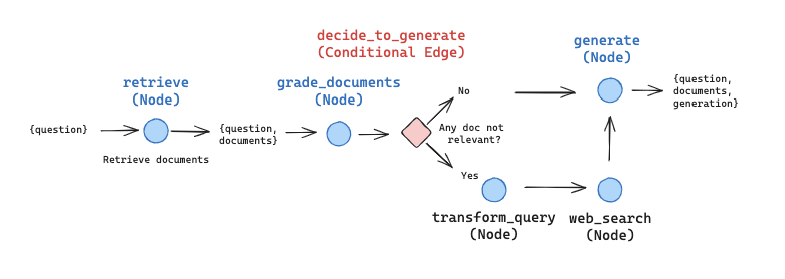


Node breakdown:

- Retrieve - Fetch documents relavent to the question
- Grade documents & Check if a doc is relavent 
- If irrelevant - Run websearch to supplement and ignore the bad fragemnt
    - If relevant we keep and add to final pool
- Finally we generate a final response


In [8]:
# State for every node

from typing import Dict, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

In [9]:
# ==========================================
# Prompt template dictionary
# ==========================================
prompt_templates = {
    "question_transform": """You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Provide an improved question without any premable, only respond with the updated question: 
        """,
    "rag_prompt": """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

        Question: {question} 

        Context: {context} 

        Answer:
        """,
    "grade_documents": """You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
        """
}

In [10]:
rag_prompt = ChatPromptTemplate.from_template(prompt_templates["rag_prompt"])

In [11]:
# ==========================================
# ==========================================
# ==========================================
# Node definitions
# ==========================================
# ==========================================
# ==========================================


# ==========================================
# Retrieve documents
# ==========================================
from pydoc import doc


def retrieve_documents(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    logger.info('--- Retrieving documents ---')
    
    # Get question
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)

    # Add to state
    return {
        "keys": {
            "documents": documents, 
            "question": question
        }
    }

# ==========================================
# Generate answer
# ==========================================
def generate_answer(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains generated answer
    """
    logger.info('--- Generating answer ---')
    
    # Get question
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Chain
    rag_chain = rag_prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {
            "documents": documents, 
            "question": question, 
            "generation": generation
       }
    }

# ==========================================
# Post-processing
# ==========================================
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# ==========================================
# Grade documents
# ==========================================
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, grade, that contains grade
    """
    logger.info('--- Grading documents - Checking relevance ---')
    
    # Get question
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = PromptTemplate(
        template=prompt_templates["grade_documents"],
        input_variables=["question", "context"],
    )

    chain = prompt | llm | JsonOutputParser() 

    # Run through documents and compile filtered documents
    filtered_docs = []
    search = "No"
    for d in documents:
        score = chain.invoke({"question": question, "context": d.page_content})
        grade = score["score"]
        if grade == "yes":
            logger.info(f"Document is relevant to the question")
            filtered_docs.append(d)
        else:
            logger.info(f"Document is not relevant to the question")
            search = "Yes" # Perform web search
            continue

    # Return filtered documents
    return {
        "keys": {
            "documents": filtered_docs, 
            "question": question, 
            "run_web_search": search
        }
    }

# ==========================================
# Transform Query to produce a better question
# ==========================================
def transform_query(state):
    """
    Transform query to produce a better question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    logger.info('--- Transforming query ---')
    
    # Get question
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = PromptTemplate(
        template=prompt_templates["question_transform"], 
        input_variables=["question"]
    )

    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})
    return {
        "keys": {
            "question": better_question,
            "documents": documents
        }
    }

# ==========================================
# Search web for relevant documents
# ==========================================
def extract_duckduckgo_docs(docs):
    final_docs = []
    for doc in docs:
        metadata = {
            "source": "DuckDuckGo",
            "title": doc.title,
            "url": doc.url
        }

        new_doc = Document(page_content=doc.content, metadata=metadata)
        final_docs.append(new_doc)

    return final_docs


def web_search(state):
    """
    Search web for relevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    logger.info('--- Performing web search ---')
    
    # Get question
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = PromptTemplate(
        template=prompt_templates["question_transform"], 
        input_variables=["question"]
    )

    # Use tavily search to get documents and add as a new document to the documents list 
    # tool = TavilySearchResults()
    # docs = tool.invoke({"query": question})
    # web_results = "\n".join([d["content"] for d in docs])
    # web_results = Document(page_content=web_results)
    # documents.append(web_results)

    # Use DuckDuckGo to search
    tool = DuckDuckGoSearchResults()
    docs = tool.run(question)
    documents.extend(extract_duckduckgo_docs(docs))

    logger.info(f"Extracted {len(docs)} documents from web search")
    
    return {
        "keys": {
            "question": question,
            "documents": documents
        }
    }


def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question for web search.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generate, that contains generate
    """
    logger.info('--- Deciding to generate new question ---')
    
    # Get question
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    search = state_dict["run_web_search"]

    # Prompt
    if search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        logger.info("--- DECISION: TRANSFORM QUERY and RUN WEB SEARCH")
        return "transform_query"
    else:
        # We have relevant documents, skip web search and go straight to generate answer
        logger.info("--- DECISION: GENERATE")
        return "generate"

## Build Graph

This is a combination of the nodes into the graph shown above

In [12]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve_documents)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate_answer)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()




# Run

In [13]:

import pprint

# Format the sate object
def format_state(stage_name, state):
    keys = state["keys"]

    # Extract relevant information. Set empty strings if not available
    documentCount = len(keys["documents"]) if "documents" in keys else 0
    question = keys["question"] if "question" in keys else ""
    generation = "Done" if "generation" in keys else "Pending"

    # Compile final str
    final_str = "\n ====== Stage Name: " + str(stage_name) + " ======\n"
    final_str += "Question: " + str(question) + "\n"
    final_str += "Document Count: " + str(documentCount) + "\n"
    if generation != "":
        final_str += "Generation: " + str(generation)

    return final_str

inputs = {
    "keys": {
        "question": "Explain when Zimbabwe was founded and who the key players were?"
    }
}


for output in app.stream(inputs):
    for key, value in output.items():
        logger.info("Currently processing node: " + key)
        logger.info(format_state(key, value))

2024-02-20 09:34:32,830 [ThreadPoolEx] [INFO ]  --- Retrieving documents ---
2024-02-20 09:34:32,830 INFO rootLogger: --- Retrieving documents ---


2024-02-20 09:34:32,856 [MainThread  ] [INFO ]  Currently processing node: retrieve
2024-02-20 09:34:32,856 INFO rootLogger: Currently processing node: retrieve
2024-02-20 09:34:32,857 [MainThread  ] [INFO ]  
 ====== Stage Name: retrieve ======
Question: Explain when Zimbabwe was founded and who the key players were?
Document Count: 4
Generation: Pending
2024-02-20 09:34:32,857 INFO rootLogger: 
 ====== Stage Name: retrieve ======
Question: Explain when Zimbabwe was founded and who the key players were?
Document Count: 4
Generation: Pending
2024-02-20 09:34:32,863 [ThreadPoolEx] [INFO ]  --- Grading documents - Checking relevance ---
2024-02-20 09:34:32,863 INFO rootLogger: --- Grading documents - Checking relevance ---
2024-02-20 09:34:33,658 [ThreadPoolEx] [INFO ]  Document is relevant to the question
2024-02-20 09:34:33,658 INFO rootLogger: Document is relevant to the question
2024-02-20 09:34:33,935 [ThreadPoolEx] [INFO ]  Document is relevant to the question
2024-02-20 09:34:33,9

In [15]:
import pprint

# Final generation
pprint.pprint(value["keys"]["generation"])

(' Zimbabwe was originally founded as the city-state of Great Zimbabwe by the '
 'Bantu people around the 9th century. The Kingdom of Zimbabwe, Rozvi, and '
 'Mutapa empires followed. In 1890, the British South Africa Company under '
 'Cecil Rhodes conquered Mashonaland and demarcated the Rhodesia region.')
